In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc,
    get_acc_EfficentNet, 
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint,
    plot_keypoints_IoU)

from torchvision.ops import (
    masks_to_boxes,
    generalized_box_iou
)
import matplotlib.patches as patches

from Keypoint_dataset import Keypoint_dataset
from torch.optim.lr_scheduler import StepLR
from models_2 import ResNet, BasicBlock, KeypointModel, KeypointCNN, EfficentNet, EfficentNet_3, UNET, KeypointModel_with_segm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 100
random.seed(42)
torch.manual_seed(42)
loss_func = nn.MSELoss()

example image


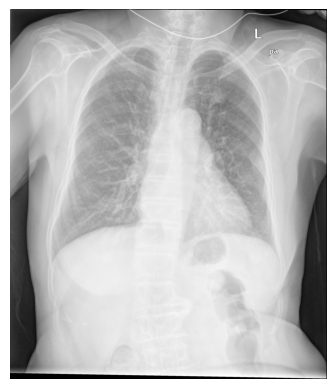

In [5]:
img_path = r'/home/alex/Documents/new try/Data/Lung Unet/data/test/images/CHNCXR_0009_0.png'
img = np.array(Image.open(img_path).convert('L'))
plt.axis('off')
plt.imshow(img, cmap='gray')


Guess Keypoint locations

r'/home/alex/Documents/new try/Data/Lung Unet/data/test/images/CHNCXR_0002_0.png'
keypoints = [(1510, 500),
                (1480, 2350),
                (470, 2280),
                (2450, 2250)
]

In [6]:
keypoints = [
            (1350, 250),
            (1160, 2080),
            (360, 1950),
            (2100, 1900)
]

Image with first keypoints

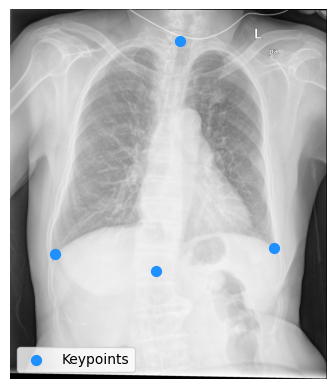

In [7]:
plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        if i == 0:
                plt.scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50, label = 'Keypoints')
        else:
                plt.scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50)
plt.legend(loc='lower left') 
plt.axis('off')    
#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_data_example.png', bbox_inches="tight")
plt.show()

Rotated


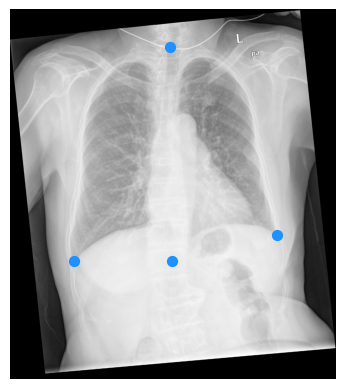

In [8]:
from scipy.ndimage import rotate
from skimage.transform import resize

keypoints_rotated = [
            (1380, 320),
            (1400, 2170),
            (550, 2170),
            (2300, 1950)
]

angle = 6
img_rotate = rotate(img, angle)
plt.imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        plt.scatter(keypoints_rotated[i][0],keypoints_rotated[i][1], color = 'dodgerblue', s = 50)
plt.axis('off')           
plt.show()

Upper lung

Acutal exposed area

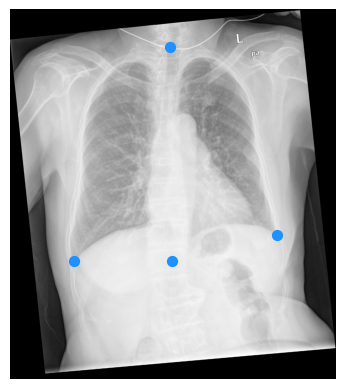

In [9]:
from scipy.ndimage import rotate
from skimage.transform import resize

keypoints_rotated = [
            (1380, 320),
            (1400, 2170),
            (550, 2170),
            (2300, 1950)
]

angle = 6
img_rotate = rotate(img, angle)
plt.imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        plt.scatter(keypoints_rotated[i][0],keypoints_rotated[i][1], color = 'dodgerblue', s = 50)
plt.axis('off')           
plt.show()

MinFS

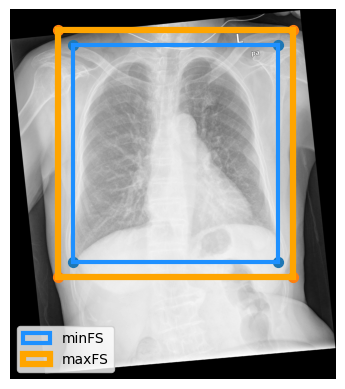

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon



keypoints_minfs = [
            (540, 310),
            (540, 2180),
            (2310, 2180),
            (2310, 310)
]



fig, ax = plt.subplots()
ax.imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
       plt.scatter(keypoints_minfs[i][0],keypoints_minfs[i][1], color = 'C0', s = 50)

polygon = Polygon(keypoints_minfs, closed=True, edgecolor= 'dodgerblue', fill=False, linewidth=3, label = 'minFS')

# Add the polygon (rectangle) to the axis
ax.add_patch(polygon)

keypoints_tolerance = [
            (410, 180),
            (410, 2310),
            (2440, 2310),
            (2440, 180)
]

for i in range(4):
       plt.scatter(keypoints_tolerance[i][0],keypoints_tolerance[i][1], color = 'C1', s = 50)
polygon = Polygon(keypoints_tolerance, closed=True, edgecolor= 'orange', fill=False, linewidth=4.5, label = 'maxFS')

# Add the polygon (rectangle) to the axis
ax.add_patch(polygon)
plt.axis('off')
plt.legend()
plt.show()

all 3 in one

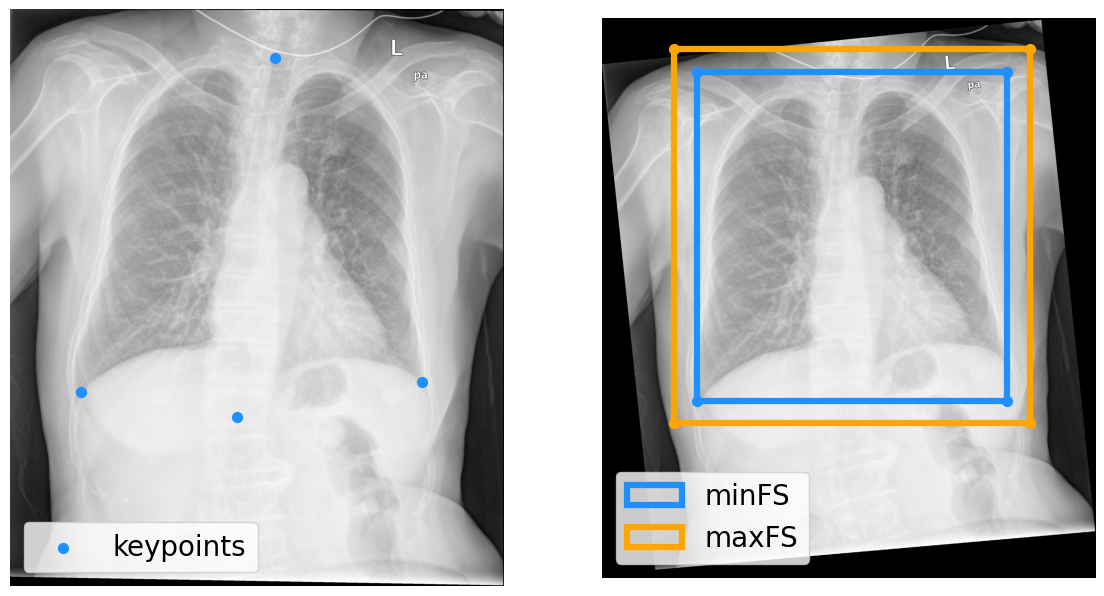

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14, 8))

ax[0].imshow(img, cmap ='gray', vmin=0, vmax=255)

for i in range(4):
        if i == 0:
                ax[0].scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50, label = 'keypoints')
        else:
                ax[0].scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50)
ax[0].axis('off') 
ax[0].legend(loc='lower left', prop={'size': 20})


ax[1].imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
       ax[1].scatter(keypoints_minfs[i][0],keypoints_minfs[i][1], color = 'dodgerblue', s = 50)

polygon = Polygon(keypoints_minfs, closed=True, edgecolor= 'dodgerblue', fill=False, linewidth=4.5, label = 'minFS')

# Add the polygon (rectangle) to the axis
ax[1].add_patch(polygon)

keypoints_tolerance = [
            (410, 180),
            (410, 2310),
            (2440, 2310),
            (2440, 180)
]

for i in range(4):
       ax[1].scatter(keypoints_tolerance[i][0],keypoints_tolerance[i][1], color = 'orange', s = 50)
polygon = Polygon(keypoints_tolerance, closed=True, edgecolor= 'orange', fill=False, linewidth=4.5, label = 'maxFS')

# Add the polygon (rectangle) to the axis
ax[1].add_patch(polygon)

ax[1].axis('off') 
ax[1].legend(loc='lower left', prop={'size': 20})

#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_example_2.png', bbox_inches="tight")
plt.show()


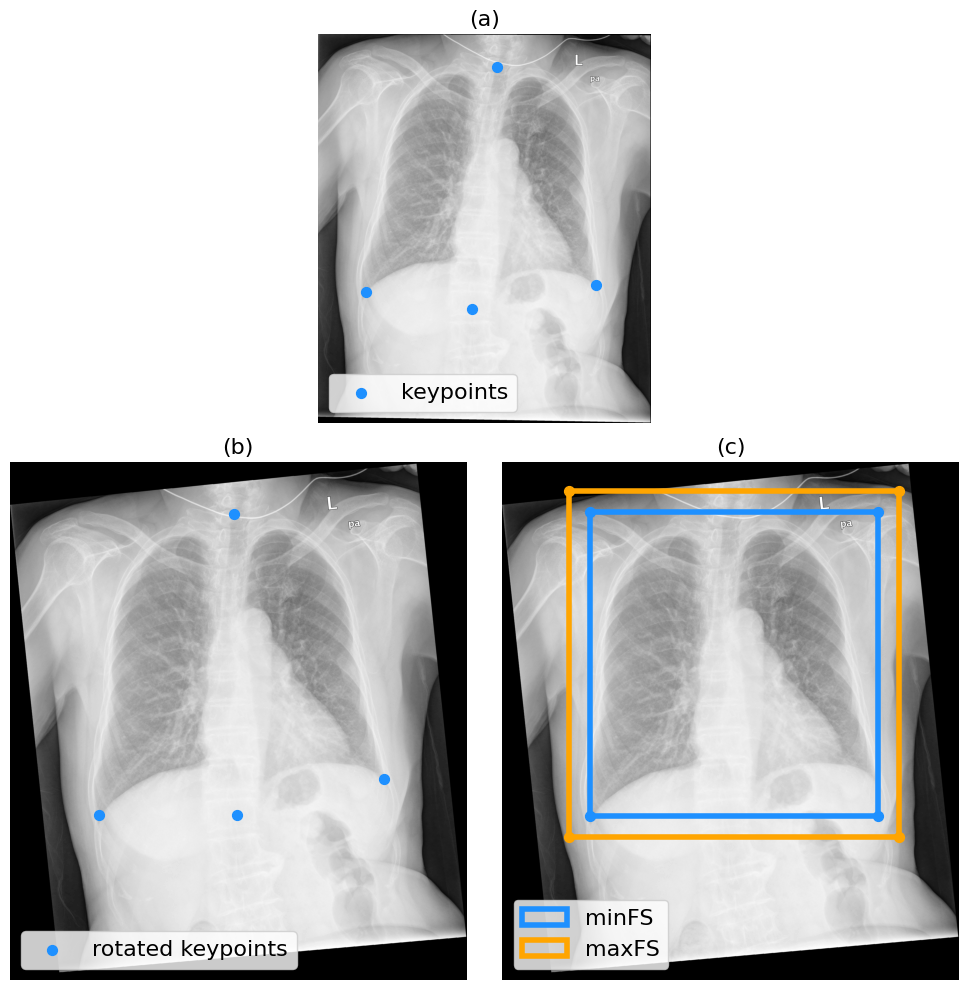

In [12]:
# Create a figure with GridSpec
fig = plt.figure(figsize=(10, 10))  # Set the figure size
gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 2])  # Make the top row smaller

# Top image (smaller)
ax1 = fig.add_subplot(gs[0, :])  # First row, spanning both columns
ax1.imshow(img, cmap = 'gray', vmin = 0, vmax = 255) 
for i in range(4):
        if i == 0:
                ax1.scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50, label = 'keypoints')
        else:
                ax1.scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50)
ax1.set_title("(a)", size = 16)
ax1.axis('off')
ax1.legend(loc='lower left', prop={'size': 16})

# Bottom left image (larger)
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
ax2.imshow(img_rotate, cmap = 'gray', vmin = 0, vmax = 255) 
for i in range(4):
        if i == 0:
                ax2.scatter(keypoints_rotated[i][0],keypoints_rotated[i][1], color = 'dodgerblue', s = 50, label = 'rotated keypoints')
        else:
                ax2.scatter(keypoints_rotated[i][0],keypoints_rotated[i][1], color = 'dodgerblue', s = 50)
ax2.set_title("(b)", size = 16)
ax2.axis('off')
ax2.legend(loc='lower left', prop={'size': 16})

# Bottom right image (larger)
ax3 = fig.add_subplot(gs[1, 1]) 
ax3.imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
      ax3.scatter(keypoints_minfs[i][0],keypoints_minfs[i][1], color = 'dodgerblue', s = 50)
ax3.set_title("(c)", size = 16)
polygon = Polygon(keypoints_minfs, closed=True, edgecolor= 'dodgerblue', fill=False, linewidth=4, label = 'minFS')

# Add the polygon (rectangle) to the axis
ax3.add_patch(polygon)

keypoints_tolerance = [
            (410, 180),
            (410, 2310),
            (2440, 2310),
            (2440, 180)
]

for i in range(4):
       ax3.scatter(keypoints_tolerance[i][0],keypoints_tolerance[i][1], color = 'orange', s = 50)
polygon = Polygon(keypoints_tolerance, closed=True, edgecolor= 'orange', fill=False, linewidth=4, label = 'maxFS')

# Add the polygon (rectangle) to the axis
ax3.add_patch(polygon)

ax3.axis('off') 
ax3.legend(loc='lower left', prop={'size': 16})


# Adjust layout to prevent overlap
plt.tight_layout()
#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_example_3.png', bbox_inches="tight")
plt.show()


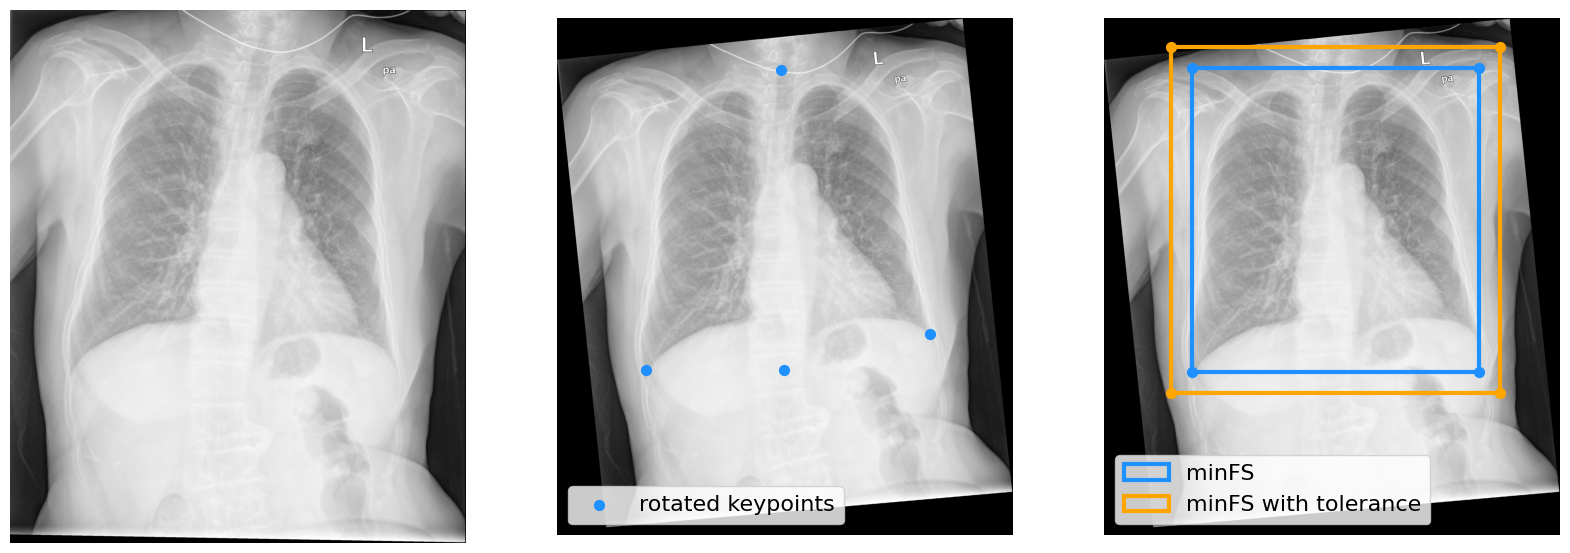

In [13]:
fig, ax = plt.subplots(1,3, figsize=(20, 10))

ax[0].imshow(img, cmap ='gray', vmin=0, vmax=255)


ax[0].axis('off') 


ax[1].imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        if i == 0:
                ax[1].scatter(keypoints_rotated[i][0],keypoints_rotated[i][1], color = 'dodgerblue', s = 50, label = 'rotated keypoints')
        else:
                ax[1].scatter(keypoints_rotated[i][0],keypoints_rotated[i][1], color = 'dodgerblue', s = 50)
ax[1].axis('off') 
ax[1].legend(loc='lower left', prop={'size': 16})



ax[2].imshow(img_rotate, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
       ax[2].scatter(keypoints_minfs[i][0],keypoints_minfs[i][1], color = 'dodgerblue', s = 50)

polygon = Polygon(keypoints_minfs, closed=True, edgecolor= 'dodgerblue', fill=False, linewidth=3, label = 'minFS')

# Add the polygon (rectangle) to the axis
ax[2].add_patch(polygon)

keypoints_tolerance = [
            (410, 180),
            (410, 2310),
            (2440, 2310),
            (2440, 180)
]

for i in range(4):
       ax[2].scatter(keypoints_tolerance[i][0],keypoints_tolerance[i][1], color = 'orange', s = 50)
polygon = Polygon(keypoints_tolerance, closed=True, edgecolor= 'orange', fill=False, linewidth=3, label = 'minFS with tolerance')

# Add the polygon (rectangle) to the axis
ax[2].add_patch(polygon)

ax[2].axis('off') 
ax[2].legend(loc='lower left', prop={'size': 16})

#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_example_3.png', bbox_inches="tight")
plt.show()


for padding reasoning makup /home/alex/Documents/new try/Data/Lung Unet/data/test/images/CHNCXR_0088_0.png


In [14]:
path = r'/home/alex/Documents/new try/Data/Lung Unet/data/test/images/CHNCXR_0088_0.png'

In [57]:

img = np.array(Image.open(path).convert('L'))[:2600,250:2500]

In [58]:
keypoints = [
            (1180, 400),
            (1200, 2200),
            (240, 2500),
            (2160, 2500)
]

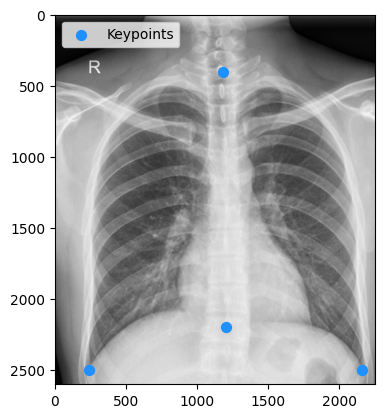

In [59]:
plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
for i in range(4):
        if i == 0:
                plt.scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50, label = 'Keypoints')
        else:
                plt.scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 50)
plt.legend(loc='upper left') 
#plt.axis('off')    
#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_data_example.png', bbox_inches="tight")
plt.show()

In [94]:
transform_padding = A.Compose(
    [
        A.Resize(height=256, width=256),
        #A.CropAndPad(px = 40, keep_size=True),
        A.Rotate(limit= 17, p = 1),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format='xy')
)

transformed = transform_padding(image= img, keypoints=keypoints)
img_trans = transformed['image']
keypoints_trans = transformed['keypoints']
keypoints_trans = torch.from_numpy(np.float32(keypoints_trans).flatten()).unsqueeze(0)[0]

In [95]:
keypoints_trans

tensor([108.3261,  41.2309, 162.0727, 210.1310])

IndexError: index 4 is out of bounds for dimension 0 with size 4

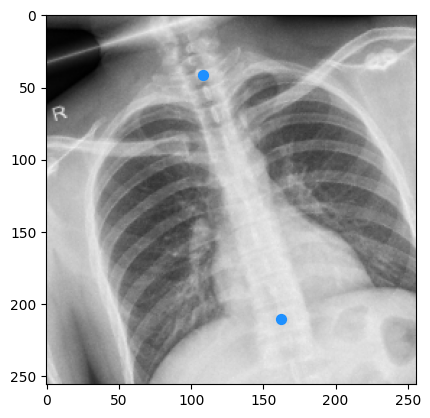

In [96]:
plt.imshow(img_trans[0], cmap ='gray', vmin=0, vmax=255)
for i in range(0,8,2):
        if i == 0:
                plt.scatter(keypoints_trans[i],keypoints_trans[i+1], color = 'dodgerblue', s = 50, label = 'Keypoints')
        else:
                plt.scatter(keypoints_trans[i],keypoints_trans[i+1], color = 'dodgerblue', s = 50)
plt.legend(loc='lower left') 
plt.axis('off')    
#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_data_example.png', bbox_inches="tight")
plt.show()

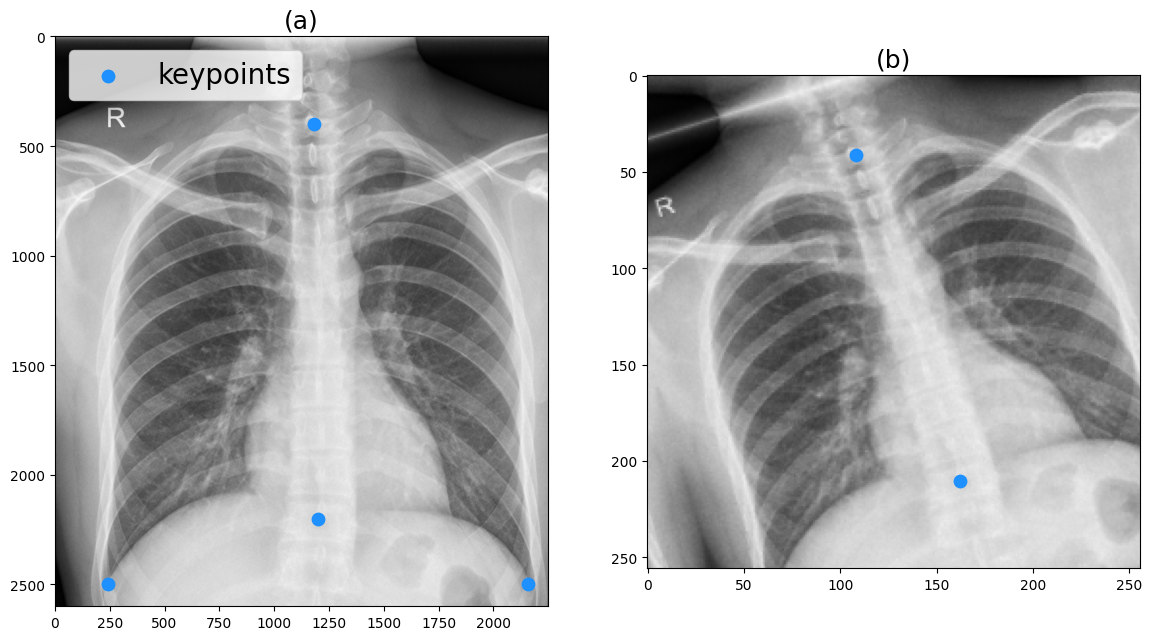

In [103]:
fig, ax = plt.subplots(1,2, figsize=(14, 8))

ax[0].imshow(img, cmap ='gray', vmin=0, vmax=255)

for i in range(4):
        if i == 0:
                ax[0].scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 80, label = 'keypoints')
        else:
                ax[0].scatter(keypoints[i][0],keypoints[i][1], color = 'dodgerblue', s = 80)
#ax[0].axis('off') 
ax[0].legend(loc='upper left', prop={'size': 20})
ax[0].set_title('(a)', size = 18)

ax[1].imshow(img_trans[0], cmap ='gray', vmin=0, vmax=255)

for i in range(0,4,2):
        if i == 0:
                ax[1].scatter(keypoints_trans[i],keypoints_trans[i+1], color = 'dodgerblue', s = 80, label = 'Keypoints')
        else:
                ax[1].scatter(keypoints_trans[i],keypoints_trans[i+1], color = 'dodgerblue', s = 80)

ax[1].set_title('(b)', size = 18)
#ax[1].axis('off') 
#ax[1].legend(loc='lower left', prop={'size': 20})

#plt.savefig(r'/home/alex/Documents/Images_thesis/keypoint_detection_rotation_problem.png', bbox_inches="tight")
plt.show()
